# SELF-SUPERVISED DENOISING: PART ONE
### Authors: Claire Birnie and Sixiu Liu, KAUST

Author websites: 
- https://cebirnie92.github.io/ 
- https://swagroup.kaust.edu.sa/people/detail/sixiu-liu-(%E5%88%98%E6%80%9D%E7%A7%80))

## Tutorial Overview

On completion of this tutorial you will have learnt how to write your own blind-spot denoising procedure that is trained in a self-supervised manner, i.e., the training data is the same as the inference data with no labels required!

### Methodology Recap
We will implement the Noise2Void 

***

In [1]:
# Import necessary packages
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 

# Our unet functions just to speed things up
from unet import UNet
from tutorial_utils import regular_patching_2D, add_whitegaussian_noise, weights_init, set_seed, make_data_loader

In [2]:
cmap='RdBu'
vmin = -0.25
vmax = 0.25

set_seed(42) # For reproducibility set random, numpy and torch seeds

True

***

# Step One - Data loading

In this example we are going to use a post-stack seismic section generated from the Hess VTI model. The post-stack section is available in the public data folder: https://exrcsdrive.kaust.edu.sa/exrcsdrive/index.php/s/vjjry6BZ3n3Ewei

with password: `kaust`

If the folder is no longer public, this is likely due to expired rights. Please email: cebirnie[at]kaust.edu.sa to request access.

In [3]:
d = np.load("./data/Hess_PostStackSection.npy")
print(d.shape)

(196, 452)


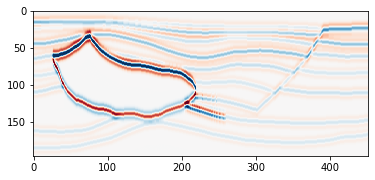

In [4]:
# Plot to see the noise free data
plt.imshow(d, cmap=cmap, vmin=vmin, vmax=vmax)

### Add noise

In [5]:
noisydata, _ = add_whitegaussian_noise(d, sc=0.1)

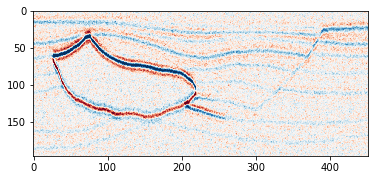

In [6]:
# plot to see the noisy data
plt.imshow(noisydata, cmap=cmap, vmin=vmin, vmax=vmax)

### Patch data

In [7]:
noisy_patches = regular_patching_2D(noisydata, 
                                    patchsize=[32, 32], 
                                    step=[6,6])

# Randomise patch order
shuffler = np.random.permutation(len(noisy_patches))
noisy_patches = noisy_patches[shuffler] 

Extracting 1960 patches


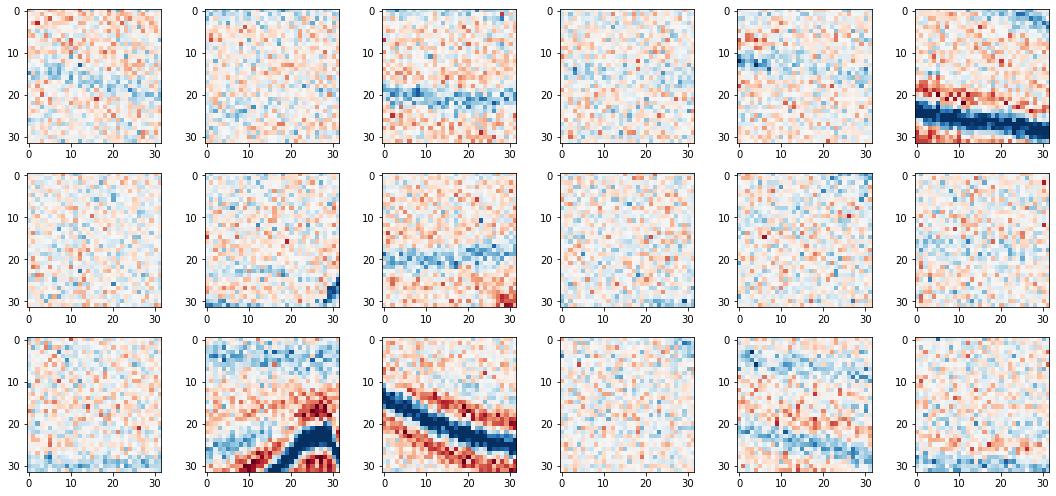

In [8]:
fig, axs = plt.subplots(3,6,figsize=[15,7])
for i in range(6*3):
    axs.ravel()[i].imshow(noisy_patches[i], cmap=cmap, vmin=vmin, vmax=vmax)
fig.tight_layout()

***

# Step Two - Blindspot corruption of training data

In [9]:
# To do: Create a function that randomly selects and corrupts pixels following N2V methodology

def multi_active_pixels(patch, 
                        num_activepixels, 
                        neighbourhood_radius=5,
                       ):

    n_rad = neighbourhood_radius  # descriptive variable name was a little long

    # Select multiple locations for active pixels
    idx_aps = np.random.randint(0, patch.shape[0], num_activepixels)
    idy_aps = np.random.randint(0, patch.shape[1], num_activepixels)

    # For each active pixel compute shift for finding neighbouring pixel and find pixel
    x_neigh_shft = np.random.randint(-n_rad // 2 + n_rad % 2, n_rad // 2 + n_rad % 2, num_activepixels)
    y_neigh_shft = np.random.randint(-n_rad // 2 + n_rad % 2, n_rad // 2 + n_rad % 2, num_activepixels)
    
    # OPTIONAL: don't allow replacement with itself
    for i in range(len(x_neigh_shft)):
        if x_neigh_shft[i] == 0 and y_neigh_shft[i] == 0:
            # This means its replacing itself with itself...not good!
            shft_options = np.trim_zeros(np.arange(-n_rad // 2 + 1, n_rad // 2 + 1))
            x_neigh_shft[i] = np.random.choice(shft_options[shft_options != 0], 1)

    # Find x and y locations of neighbours for the replacement
    idx_neigh = idx_aps + x_neigh_shft
    idy_neigh = idy_aps + y_neigh_shft

    # Make sure neighbouring pixels within window
    idx_neigh = idx_neigh + (idx_neigh < 0) * patch.shape[0] - (idx_neigh >= patch.shape[0]) * patch.shape[0]
    idy_neigh = idy_neigh + (idy_neigh < 0) * patch.shape[1] - (idy_neigh >= patch.shape[1]) * patch.shape[1]
    
    # combine x and y coordinates for active pixels and neighbouring pixels
    id_aps = (idx_aps, idy_aps)
    id_neigh = (idx_neigh, idy_neigh)
    
    # Make mask and corrupted patch
    mask = np.ones_like(patch)
    cp_ptch = patch.copy()
    mask[id_aps] = 0.
    cp_ptch[id_aps] = patch[id_neigh]

    return cp_ptch, mask


In [10]:
# Check the corruption function works
crpt_patch, mask = multi_active_pixels(noisy_patches[0], 
                                       num_activepixels=50, 
                                       neighbourhood_radius=5, 
                                      )

Text(0.5, 1.0, 'Corruption Mask')

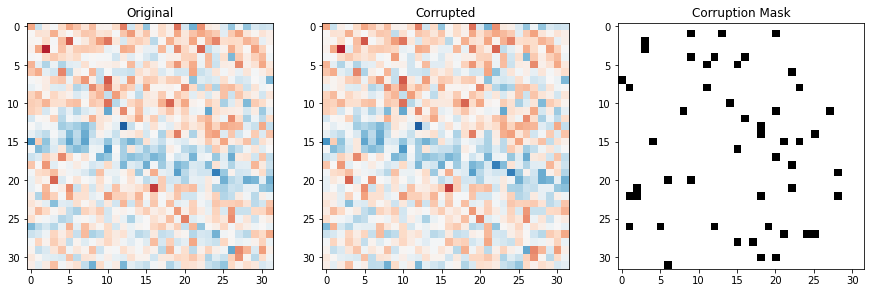

In [11]:
fig,axs = plt.subplots(1,3,figsize=[15,5])
axs[0].imshow(noisy_patches[0], cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].imshow(crpt_patch, cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].imshow(mask, cmap='binary_r')

axs[0].set_title('Original')
axs[1].set_title('Corrupted')
axs[2].set_title('Corruption Mask')

***

# Step three - Set up network

In [12]:
# Select device for training
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = torch.device(torch.cuda.current_device())
    print(f'Device: {device} {torch.cuda.get_device_name(device)}')
else:
    print("No GPU available!")

Cuda installed! Running on GPU!
Device: cuda:0 NVIDIA Tesla V100-SXM2-32GB


In [13]:
# Build UNet
network = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=2).to(device)

network = network.apply(weights_init) 

/ibex/scratch/birniece/Transform2022_SelfSupervisedDenoising/tutorial_utils.py:117: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)
/ibex/scratch/birniece/Transform2022_SelfSupervisedDenoising/tutorial_utils.py:118: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


In [14]:
# Network initialisation steps
lr = 0.0001
criterion = nn.MSELoss()
optim = torch.optim.Adam(network.parameters(), lr=lr)

***

# Step four - training

In [15]:
# Selecting the percent of active pixels
perc_active = 5
total_num_pixels = noisy_patches[0].shape[0]*noisy_patches[0].shape[1]
num_activepixels = np.floor((total_num_pixels/100) * perc_active)

In [16]:
# Choose the number of epochs
n_epochs = 20

# Choose number of training samples
n_training = 1280
n_test = 256
batch_size = 128
    
# Initial train and val 
train_loss_history = np.zeros(n_epochs)
train_accuracy_history = np.zeros(n_epochs)
test_loss_history = np.zeros(n_epochs)
test_accuracy_history = np.zeros(n_epochs)

# Create DataLoaders fixing the generator for reproducibily
g = torch.Generator()
g.manual_seed(0)

In [17]:
# Training Function
def n2v_train(model, 
              criterion, 
              optimizer, 
              data_loader, 
              device):
    
    model.train()
    accuracy = 0
    loss = 0

    for dl in tqdm(data_loader):
        X, y, mask = dl[0], dl[1], dl[2]
        X, y, mask = X.to(device), y.to(device), mask.to(device)
        optimizer.zero_grad()
        yprob = model(X)

        # TO DO: Compute loss function only at masked locations
        # (Hint: only one line required)
        ls = criterion(yprob * (1 - mask), y * (1 - mask))
        
        ls.backward()
        optimizer.step()
        with torch.no_grad():
            yprob = yprob
            ypred = (yprob.detach().cpu().numpy()).astype(float)
        loss += ls.item()
        accuracy += np.sqrt(np.mean((y.cpu().numpy().ravel( ) - ypred.ravel() )**2))
        
    loss /= len(data_loader)
    accuracy /= len(data_loader)   

    return loss, accuracy

In [18]:
# Validation Function
def n2v_evaluate(model,
                 criterion, 
                 optimizer, 
                 data_loader, 
                 device):
    
    model.train()
    accuracy = 0
    loss = 0

    for dl in tqdm(data_loader):
        X, y, mask = dl[0], dl[1], dl[2]
        X, y, mask = X.to(device), y.to(device), mask.to(device)
        optimizer.zero_grad()
        yprob = model(X)

        with torch.no_grad():
            
            # TO DO: Compute loss function only at masked locations
            # (Hint: only one line required)
            ls = criterion(yprob * (1 - mask), y * (1 - mask))
     
            ypred = (yprob.detach().cpu().numpy()).astype(float)
        loss += ls.item()
        accuracy += np.sqrt(np.mean((y.cpu().numpy().ravel( ) - ypred.ravel() )**2))
        
    loss /= len(data_loader)
    accuracy /= len(data_loader)

    return loss, accuracy

In [19]:
# TRAINING
for ep in range(n_epochs):  
        
    # RANDOMLY CORRUPT THE NOISY PATCHES
    corrupted_patches = np.zeros_like(noisy_patches)
    masks = np.zeros_like(corrupted_patches)
    for pi in range(len(noisy_patches)):
        corrupted_patches[pi], masks[pi] = multi_active_pixels(noisy_patches[pi], 
                                                               num_activepixels=int(num_activepixels), 
                                                               neighbourhood_radius=5, 
                                                              )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # MAKE DATA LOADERS
    train_loader, test_loader = make_data_loader(noisy_patches, 
                                                 corrupted_patches, 
                                                 masks, 
                                                 n_training,
                                                 n_test,
                                                 batch_size = 128,
                                                 torch_generator=g
                                                )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # TRAIN
    train_loss, train_accuracy = n2v_train(network, 
                                           criterion, 
                                           optim, 
                                           train_loader, 
                                           device,)
    train_loss_history[ep], train_accuracy_history[ep] = train_loss, train_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # EVALUATE (AKA VALIDATION)
    test_loss, test_accuracy = n2v_evaluate(network, 
                                            criterion,
                                            optim,
                                            test_loader, 
                                            device,)
    test_loss_history[ep], test_accuracy_history[ep] = test_loss, test_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # PRINTING TRAINING PROGRESS
    print(f'''Epoch {ep}, 
    Training Loss {train_loss:.4f},     Training Accuracy {train_accuracy:.4f}, 
    Test Loss {test_loss:.4f},     Test Accuracy {test_accuracy:.4f} ''')



100%|██████████| 2/2 [00:00<00:00, 11.42it/s]


Epoch 0, 
    Training Loss 0.0009,     Training Accuracy 0.1350, 
    Test Loss 0.0007,     Test Accuracy 0.1189 


100%|██████████| 2/2 [00:00<00:00, 11.78it/s]


Epoch 1, 
    Training Loss 0.0007,     Training Accuracy 0.1141, 
    Test Loss 0.0006,     Test Accuracy 0.1082 


100%|██████████| 2/2 [00:00<00:00, 11.55it/s]


Epoch 2, 
    Training Loss 0.0006,     Training Accuracy 0.1083, 
    Test Loss 0.0006,     Test Accuracy 0.1067 


100%|██████████| 2/2 [00:00<00:00, 22.59it/s]


Epoch 3, 
    Training Loss 0.0006,     Training Accuracy 0.1072, 
    Test Loss 0.0006,     Test Accuracy 0.1072 


100%|██████████| 2/2 [00:00<00:00, 11.69it/s]


Epoch 4, 
    Training Loss 0.0006,     Training Accuracy 0.1075, 
    Test Loss 0.0006,     Test Accuracy 0.1071 


100%|██████████| 2/2 [00:00<00:00, 11.90it/s]


Epoch 5, 
    Training Loss 0.0006,     Training Accuracy 0.1068, 
    Test Loss 0.0006,     Test Accuracy 0.1059 


100%|██████████| 2/2 [00:00<00:00, 11.78it/s]


Epoch 6, 
    Training Loss 0.0006,     Training Accuracy 0.1061, 
    Test Loss 0.0006,     Test Accuracy 0.1057 


100%|██████████| 2/2 [00:00<00:00, 11.86it/s]


Epoch 7, 
    Training Loss 0.0006,     Training Accuracy 0.1062, 
    Test Loss 0.0006,     Test Accuracy 0.1065 


100%|██████████| 2/2 [00:00<00:00, 22.70it/s]


Epoch 8, 
    Training Loss 0.0006,     Training Accuracy 0.1068, 
    Test Loss 0.0006,     Test Accuracy 0.1064 


100%|██████████| 2/2 [00:00<00:00, 11.79it/s]


Epoch 9, 
    Training Loss 0.0006,     Training Accuracy 0.1064, 
    Test Loss 0.0006,     Test Accuracy 0.1058 


100%|██████████| 2/2 [00:00<00:00, 12.14it/s]


Epoch 10, 
    Training Loss 0.0006,     Training Accuracy 0.1064, 
    Test Loss 0.0005,     Test Accuracy 0.1061 


100%|██████████| 2/2 [00:00<00:00, 11.29it/s]


Epoch 11, 
    Training Loss 0.0006,     Training Accuracy 0.1065, 
    Test Loss 0.0006,     Test Accuracy 0.1064 


100%|██████████| 2/2 [00:00<00:00, 11.96it/s]


Epoch 12, 
    Training Loss 0.0005,     Training Accuracy 0.1066, 
    Test Loss 0.0005,     Test Accuracy 0.1064 


100%|██████████| 2/2 [00:00<00:00, 22.63it/s]


Epoch 13, 
    Training Loss 0.0006,     Training Accuracy 0.1065, 
    Test Loss 0.0005,     Test Accuracy 0.1062 


100%|██████████| 2/2 [00:00<00:00, 11.83it/s]


Epoch 14, 
    Training Loss 0.0006,     Training Accuracy 0.1063, 
    Test Loss 0.0005,     Test Accuracy 0.1057 


100%|██████████| 2/2 [00:00<00:00, 11.38it/s]


Epoch 15, 
    Training Loss 0.0005,     Training Accuracy 0.1060, 
    Test Loss 0.0005,     Test Accuracy 0.1058 


100%|██████████| 2/2 [00:00<00:00, 11.97it/s]


Epoch 16, 
    Training Loss 0.0005,     Training Accuracy 0.1061, 
    Test Loss 0.0005,     Test Accuracy 0.1059 


100%|██████████| 2/2 [00:00<00:00, 12.19it/s]


Epoch 17, 
    Training Loss 0.0005,     Training Accuracy 0.1060, 
    Test Loss 0.0005,     Test Accuracy 0.1057 


100%|██████████| 2/2 [00:00<00:00, 23.39it/s]


Epoch 18, 
    Training Loss 0.0005,     Training Accuracy 0.1059, 
    Test Loss 0.0005,     Test Accuracy 0.1056 


100%|██████████| 2/2 [00:00<00:00, 11.57it/s]

Epoch 19, 
    Training Loss 0.0005,     Training Accuracy 0.1054, 
    Test Loss 0.0005,     Test Accuracy 0.1052 


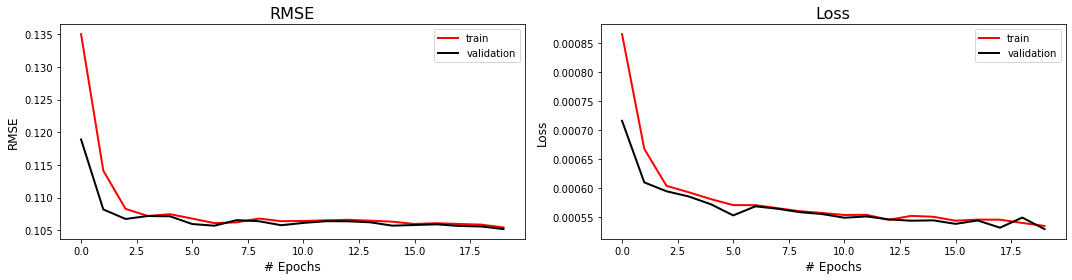

In [20]:
fig,axs = plt.subplots(1,2,figsize=(15,4))

axs[0].plot(train_accuracy_history, 'r', lw=2, label='train')
axs[0].plot(test_accuracy_history, 'k', lw=2, label='validation')
axs[0].set_title('RMSE', size=16)
axs[0].set_ylabel('RMSE', size=12)

axs[1].plot(train_loss_history, 'r', lw=2, label='train')
axs[1].plot(test_loss_history, 'k', lw=2, label='validation')
axs[1].set_title('Loss', size=16)
axs[1].set_ylabel('Loss', size=12)


for ax in axs:
    ax.legend()
    ax.set_xlabel('# Epochs', size=12)
fig.tight_layout()

***

## Step five - apply trained model

In [21]:
# Make a new noisy realisation so it's different from the training set
testdata, _ = add_whitegaussian_noise(d, sc=0.1)

In [22]:
torch_testdata = torch.from_numpy(np.expand_dims(np.expand_dims(testdata,axis=0),axis=0)).float()
test_prediction = network(torch_testdata.to(device))
test_pred = test_prediction.detach().cpu().numpy().squeeze()

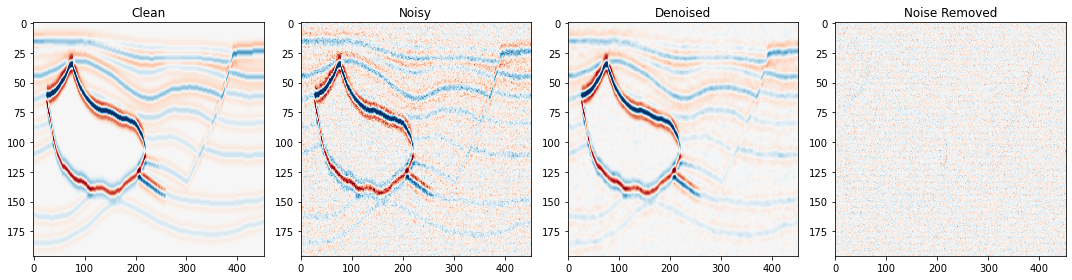

In [23]:
fig,axs = plt.subplots(1,4,figsize=[15,4])
axs[0].imshow(d[:196,:452], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].imshow(testdata, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].imshow(test_pred, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
axs[3].imshow(testdata-test_pred, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)

axs[0].set_title('Clean')
axs[1].set_title('Noisy')
axs[2].set_title('Denoised')
axs[3].set_title('Noise Removed')

fig.tight_layout()